## Predicting News Headline Popularity 

This notebook explores the prediction of news headline popularity. This prediction task has business relevance for many media oulets that rely on online readership, who supply subscription members and ad views, in order to generate revenue.

<br>

The dataset is a collection of news headlines from the Reddit /worldnews subreddit. The popularity of each headline is measured by the number of upvotes it receives from users. Different prediction models, including sklearn Regressors, XGBoost, and CatBoost, are compared for performance.

<br>

### Table of Contents:
 ---
##### 1. Text Preprocessing

##### 2. Sentiment Analysis and Score Calculation

##### 3. Word Embedding and Vectorization with Word2Vec

##### 4. Modeling with XGBoost and CatBoost

##### 5. Results and Analysis

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
%cd "/content/drive/My Drive/Coding Challenges"
!pwd

/content/drive/My Drive/Coding Challenges
/content/drive/My Drive/Coding Challenges


In [3]:
import os

import sys 
print(f"Python version is {sys.version}")

import pandas as pd 
print(f"pandas version is {pd.__version__}")

import matplotlib.pyplot as plt

import seaborn as sns
print(f"seaborn version is {sns.__version__}")

import numpy as np
print(f"NumPy version is {np.__version__}")

import scipy as sp 
print(f"SciPy version is {sp.__version__}")

import sklearn 
print(f"scikit-learn version is {sklearn.__version__}")

import cv2
import IPython
from six.moves import urllib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

!pip install catboost
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow import keras
print(keras.__version__)
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

import warnings
warnings.filterwarnings('ignore')

Python version is 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
pandas version is 0.25.3
seaborn version is 0.10.0
NumPy version is 1.17.5
SciPy version is 1.4.1
scikit-learn version is 0.22.1


2.2.4-tf


In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [0]:
import gensim
# import gensim.downloader as api
# from gensim.test.utils import common_texts
from gensim.models import Word2Vec

In [0]:
downloaded = drive.CreateFile({'id':'15X00ZWBjla7qGOIW33j8865QdF89IyAk'}) 
downloaded.GetContentFile('Eluvio_DS_Challenge.csv')  
reader = pd.read_csv('Eluvio_DS_Challenge.csv', chunksize=2_000_000)

In [0]:
df = reader.get_chunk(1_000_000)  # get smaller chunk of data to work with
ref = df.iloc[0:100]  # reference orig data
ref2 = df[:] # full copy of df

In [0]:
df.shape  # ~500k rows

(509236, 8)

In [0]:
df.columns

Index(['time_created', 'date_created', 'up_votes', 'down_votes', 'title',
       'over_18', 'author', 'category'],
      dtype='object')

In [0]:
df.drop(['time_created', 'author', 'over_18', 'category'], axis=1, inplace=True)

## Text Preprocessing
Steps:
1. Remove punctuation and stopwords. Convert to lower case.
2. Tokenization
3. Stemming

In [0]:
## TEXT CLEANING

# remove punctuation
df['title'] = df['title'].str.replace('[^\w\s]','')

# convert all to lower case
df['title'] = df['title'].str.lower()

In [0]:
# tokenize headlines into lists of words
df['tokenized'] = df.apply(lambda row: wordpunct_tokenize(row['title']), axis=1)

In [0]:
# remove stop words
stop = set(stopwords.words('english'))
df['tokenized'] = df['tokenized'].apply(lambda row: [word for word in row if word not in stop])

In [0]:
# Stemming
# Use English stemmer.
stemmer = SnowballStemmer("english")

# stem all words
test1 = df[:]
test1['stemmed'] = test1['tokenized'].apply(lambda x: [stemmer.stem(y) for y in x]) 

In [0]:
# get length of each headline 
df['title_len'] = df.apply(lambda row: len(row['tokenized']), axis=1)

,date_created,up_votes,down_votes,title,tokenized,title_len
0,2008-01-25,3,0,scores killed in pakistan clashes,"[scores, killed, pakistan, clashes]",5
1,2008-01-25,2,0,japan resumes refuelling mission,"[japan, resumes, refuelling, mission]",4
2,2008-01-25,3,0,us presses egypt on gaza border,"[us, presses, egypt, gaza, border]",6
3,2008-01-25,1,0,jumpstart economy give health care to all,"[jumpstart, economy, give, health, care]",7
4,2008-01-25,4,0,council of europe bashes euun terror blacklist,"[council, europe, bashes, euun, terror, blackl...",7


## Sentiment Score Calculation
<a href="#sentiment"></a>

In [0]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)
df_train_title = df_train['tokenized']
df_test_title = df_test['tokenized']

In [0]:
sentim_analyzer = SentimentAnalyzer()
all_words_neg = sentim_analyzer.all_words([mark_negation(title) for title in df_train_title])
unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

In [0]:
sid = SentimentIntensityAnalyzer()

compound=[]
neg=[]
neu=[]
pos=[]

for title in df['title']:
  # print(title)
  ss = sid.polarity_scores(title)
  compound.append(ss['compound'])
  neg.append(ss['neg'])
  neu.append(ss['neu'])
  pos.append(ss['pos'])

In [0]:
# add new sentiments to df
df['compound_sentiment'] = np.array(compound)
df['neg_sentiment'] = np.array(neg)
df['neu_sentiment'] = np.array(neu)
df['pos_sentiment'] = np.array(pos)


## Word Embeddings and Vectorization
<a href="#word"></a>

In [0]:
# build vocabulary and train model
model = gensim.models.Word2Vec(
    df['tokenized'],
    size=150,
    window=10,
    min_count=2,
    workers=10,
    iter=10)

In [0]:
# # can test the word vector similarity func
# w1 = "president"
# model.wv.most_similar(positive=w1)

In [0]:
model.save("word2vec.model")

In [0]:
word_vectors = model.wv
type(word_vectors)

gensim.models.keyedvectors.Word2VecKeyedVectors

In [0]:
X = []

# for title in df['tok_clean']:
for title in df['tokenized']:
  means = []
  for word in title:
    if word in word_vectors.vocab:
      mean = np.mean(np.array(word_vectors[word]))
      means.append(mean)
  X.append(means)

In [0]:
# X contains the average vector rep for each word per title
print(len(X))
print(df.shape)

509236
(509236, 12)


In [0]:
# take average for whole title
X_avg = []
for i in X:
    i_ = i if type(i) is list else [i]
    if len(i_) != 0:
      X_avg.append(sum(i_)/float(len(i_)))
    else:
      X_avg.append(0)

In [0]:
df["avg_vec"] = pd.Series(X_avg)

In [0]:
df.head()

,Unnamed: 0,date_created,up_votes,down_votes,title,tokenized,title_len,compound_sentiment,neg_sentiment,neu_sentiment,pos_sentiment,avg_vec
0,0,2008-01-25,3,0,scores killed in pakistan clashes,"['scores', 'killed', 'pakistan', 'clashes']",5,-0.6705,0.529,0.471,0.000,0.028914
1,1,2008-01-25,2,0,japan resumes refuelling mission,"['japan', 'resumes', 'refuelling', 'mission']",4,0.0000,0.000,1.000,0.000,0.032777
2,2,2008-01-25,3,0,us presses egypt on gaza border,"['us', 'presses', 'egypt', 'gaza', 'border']",6,0.0000,0.000,1.000,0.000,0.011322
3,3,2008-01-25,1,0,jumpstart economy give health care to all,"['jumpstart', 'economy', 'give', 'health', 'ca...",7,0.4939,0.000,0.652,0.348,0.015898
4,4,2008-01-25,4,0,council of europe bashes euun terror blacklist,"['council', 'europe', 'bashes', 'euun', 'terro...",7,-0.5267,0.362,0.638,0.000,0.023960


## Modeling
<a href="#modeling"></a>

In [0]:
# continue
df = pd.read_csv("data_to_model.csv")

In [0]:
df2 = df.sample(10_000)
X = df2[['title_len', 'compound_sentiment', 'neg_sentiment', 'neu_sentiment', 'pos_sentiment', 'avg_vec']]
y = df2['up_votes']

In [8]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10000, 6) (10000,) (6700, 6) (3300, 6) (6700,) (3300,)


In [0]:
# Begin sklearn Regressor modeling

In [0]:
reg1 = GradientBoostingRegressor(n_estimators=50,
                                  criterion="mse",
                                  max_features="auto")

reg2 = RandomForestRegressor(n_estimators=50,
                                  criterion="mse",
                                  max_features="auto")

reg1.fit(X_train, y_train)
y_pred1 = reg1.predict(X_test)

reg2.fit(X_train, y_train)
y_pred2 = reg2.predict(X_test)


In [0]:
print("Metrics for GradientBoostingRegressor:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred1)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred1)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test, y_pred1, squared=False)}")
print(f"R2 Score: {r2_score(y_test, y_pred1)}")

Metrics for GradientBoostingRegressor:
Mean Absolute Error: 168.27861404842528
Mean Squared Error: 238555.22271074186
Root Mean Squared Error: 488.4211530131981
R2 Score: -0.029180503954375103


In [0]:
print("Metrics for RandomForestRegressor:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred2)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred2)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test, y_pred2, squared=False)}")
print(f"R2 Score: {r2_score(y_test, y_pred2)}")

Metrics for RandomForestRegressor:
Mean Absolute Error: 186.18039525252527
Mean Squared Error: 269624.3638453456
Root Mean Squared Error: 519.2536604063043
R2 Score: -0.1632197170430485


In [0]:
# Begin xgboost and catboost modeling

In [0]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred3 = model.predict(X_test)

[07:25:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
print("Metrics for XGBoost:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred3)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred3)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test, y_pred3, squared=False)}")
print(f"R2 Score: {r2_score(y_test, y_pred3)}")

Metrics for XGBoost:
Mean Absolute Error: 168.91247396643413
Mean Squared Error: 238687.659935655
Root Mean Squared Error: 488.556711074216
R2 Score: -0.029751867717991765


In [0]:
model2 = CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
model2.fit(X_train, y_train)
y_pred4 = model2.predict(X_test)

In [0]:
print("Metrics for CatBoost:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred4)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred4)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test, y_pred4, squared=False)}")
print(f"R2 Score: {r2_score(y_test, y_pred4)}")

Metrics for CatBoost:
Mean Absolute Error: 166.16241185762624
Mean Squared Error: 232438.94068590266
Root Mean Squared Error: 482.1192183328753
R2 Score: -0.002793497436040404


## Results and Analysis
<a href="#results"></a>


From the results of the regression, CatBoost has the lowest RMSE score and therefore best optimal model given constraints. In the future, more analysis on other features, such as time released and article content and upvote/downvote ratio, would give greater insight and accuracy to the phenomenon of higher readership and popularity for certain articles.

In [0]:
scores = {"GradientBoostingRegressor": mean_squared_error(y_test, y_pred1, squared=False),
              "RandomForestRegressor": mean_squared_error(y_test, y_pred2, squared=False),
              "XGBoost": mean_squared_error(y_test, y_pred3, squared=False),
              "CatBoost": mean_squared_error(y_test, y_pred4, squared=False)}

Text(0.5, 1.0, 'Scores of Models')

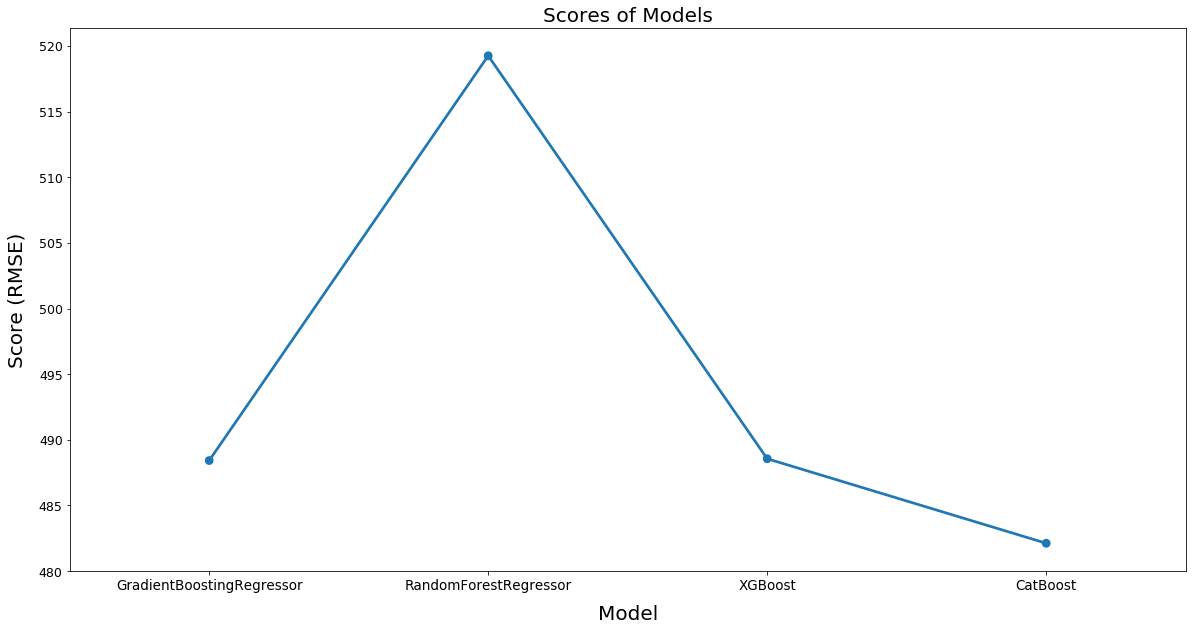

In [0]:
fig = plt.figure(figsize=(20, 10))

ax = sns.pointplot(x = list(scores.keys()), y= [score for score in scores.values()])

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

In [0]:
pred = pd.Series(y_pred4)
y_test.reset_index(drop=True, inplace=True)
pred.reset_index(drop=True, inplace=True)
test_results = pd.concat([y_test, pred], axis=1)
test_results.columns=["up_votes", "predicted_up_votes"]

In [0]:
test_results.to_csv("predictions.csv")